In [15]:
import cv2
import numpy as np

def generate_tissue_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask


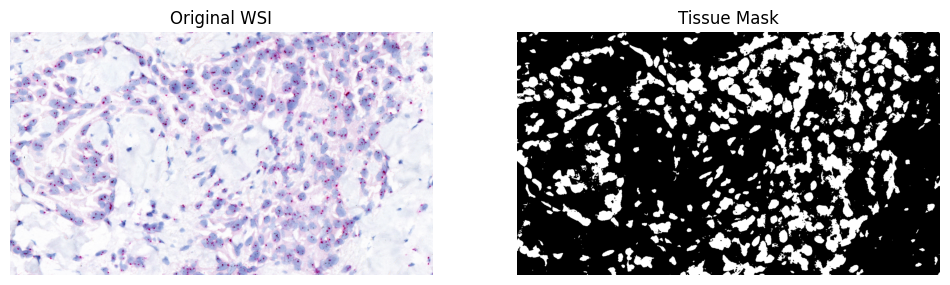

In [16]:
import matplotlib.pyplot as plt

img = cv2.imread("/kaggle/input/her2-sish-dataset/Non-Amplified Samples/168136629.png")
mask = generate_tissue_mask(img)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Original WSI")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Tissue Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

In [4]:
from skimage import color
import numpy as np

# =================================================
# Reinhard color normalization (scikit‑image)
# =================================================

def reinhard_normalize(source, target):
    """
    Normalize the color distribution of `source` to match `target`
    using Reinhard method in Lab color space.
    
    source, target: RGB images (0–255)
    returns: normalized RGB (0–255)
    """
    # to float
    src = source.astype(np.float32) / 255.0
    tgt = target.astype(np.float32) / 255.0
    
    # convert to Lab
    src_lab = color.rgb2lab(src)
    tgt_lab = color.rgb2lab(tgt)
    
    # match channel means & stds
    src_mean = src_lab.mean(axis=(0,1))
    src_std  = src_lab.std(axis=(0,1))
    tgt_mean = tgt_lab.mean(axis=(0,1))
    tgt_std  = tgt_lab.std(axis=(0,1))
    
    # normalize
    norm_lab = (src_lab - src_mean) * (tgt_std / (src_std + 1e-8)) + tgt_mean
    norm_rgb = color.lab2rgb(norm_lab)
    
    # back to 0–255 uint8
    norm_rgb = np.clip(norm_rgb * 255, 0, 255).astype(np.uint8)
    
    return norm_rgb


In [5]:
# Reference patch for stain normalization
REF_PATCH_PATH = "/kaggle/input/her2-sish-dataset/Non-Amplified Samples/168136629.png"
REF_RGB = cv2.cvtColor(cv2.imread(REF_PATCH_PATH), cv2.COLOR_BGR2RGB)

def normalize_patch(patch, ref=REF_RGB):
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    norm_rgb = reinhard_normalize(patch_rgb, ref)
    return cv2.cvtColor(norm_rgb, cv2.COLOR_RGB2BGR)

def extract_patches(img, mask, save_dir, slide_id):
    for PATCH_SIZE, STRIDE in zip(PATCH_SIZES, STRIDES):
        h, w, _ = img.shape
        for y in range(0, h - PATCH_SIZE + 1, STRIDE):
            for x in range(0, w - PATCH_SIZE + 1, STRIDE):
                patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                mask_patch = mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                tissue_ratio = np.sum(mask_patch > 0) / (PATCH_SIZE * PATCH_SIZE)
                if tissue_ratio >= TISSUE_THRESHOLD:
                    patch = normalize_patch(patch)  # Use scikit-image based normalization
                    patch_resized = cv2.resize(patch, (224,224))
                    patch_name = f"{slide_id}_scale{PATCH_SIZE}_x{x}_y{y}.png"
                    cv2.imwrite(os.path.join(save_dir, patch_name), patch_resized)


In [6]:
def process_wsi(image_path, label_name, output_root):
    # Get slide ID from filename
    slide_id = os.path.splitext(os.path.basename(image_path))[0]

    # Read image
    img = cv2.imread(image_path)

    # Generate tissue mask
    mask = generate_tissue_mask(img)

    # Make save directory
    save_dir = os.path.join(output_root, label_name)
    os.makedirs(save_dir, exist_ok=True)

    # Extract patches (multi-scale, stain-normalized)
    extract_patches(img, mask, save_dir, slide_id)


In [17]:
import os
from tqdm import tqdm

PATCH_SIZES = [224, 448]  # Multi-scale
STRIDES = [224, 448]
TISSUE_THRESHOLD = 0.7

DATASET_ROOT = "/kaggle/input/her2-sish-dataset"
PATCH_ROOT = "/kaggle/working/patches"

classes = {
    "Amplified Samples": "Amplified",
    "Non-Amplified Samples": "Non_Amplified",
    "ROI_Normal": "ROI_Normal"
}

for folder, label in classes.items():
    folder_path = os.path.join(DATASET_ROOT, folder)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        if img_name.lower().endswith((".png", ".jpg")):
            process_wsi(
                os.path.join(folder_path, img_name),
                label,
                PATCH_ROOT
            )

Processing Amplified:   0%|          | 0/113 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [12]:
!ls /kaggle/working/patches/Amplified | head

168138400_scale224_x896_y2464.png
168139738_scale224_x1120_y224.png
168139738_scale224_x1344_y224.png
168139738_scale224_x1792_y1568.png
168139738_scale224_x672_y0.png
168139881_scale224_x3808_y672.png
169262605_scale224_x1792_y1792.png
169262605_scale224_x1792_y2464.png
169262605_scale224_x2016_y1792.png
169262605_scale224_x896_y2240.png
ls: write error: Broken pipe


In [18]:
# Root Dataset count
print("WSI count per class:")
for folder in os.listdir(DATASET_ROOT):
    folder_path = os.path.join(DATASET_ROOT, folder)
    
    if os.path.isdir(folder_path):
        count = sum(
            1 for f in os.listdir(folder_path)
            if f.lower().endswith((".png", ".jpg"))
        )
        print(f"{folder}: {count}")

# Patch Data count
print("\nPatch count per class:")
for folder in os.listdir(PATCH_ROOT):
    folder_path = os.path.join(PATCH_ROOT, folder)
    
    if os.path.isdir(folder_path):
        count = sum(
            1 for f in os.listdir(folder_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        )
        print(f"{folder}: {count}")

WSI count per class:
Amplified Samples: 113
ROI_Normal: 300
Non-Amplified Samples: 124

Patch count per class:
Non_Amplified: 762
Amplified: 714
ROI_Normal: 282


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

BATCH_SIZE = 16
IMG_SIZE = (224, 224)
SEED = 123

# Train = 70%
train_ds = tf.keras.utils.image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

# Temp = 30% (will become val + test)
temp_ds = tf.keras.utils.image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 1758 files belonging to 3 classes.
Using 1231 files for training.
Found 1758 files belonging to 3 classes.
Using 527 files for validation.
Class names: ['Amplified', 'Non_Amplified', 'ROI_Normal']


In [20]:
# Number of batches in temp dataset
temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()

# Split evenly
val_batches = temp_batches // 2
test_batches = temp_batches - val_batches

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

y_train = []

for _, labels in train_ds:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.8141534391534392), 1: np.float64(0.7936814958091554), 2: np.float64(1.953968253968254)}


In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.25),
    tf.keras.layers.GaussianNoise(0.05),
])

In [23]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Activation, Dense, Multiply, Add, Dropout
)

In [24]:
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize

# --- 1. Provided Reference Functions ---

def _iso_winsor_numpy_flat(x_batch_np, contamination=0.05, win_limit=0.05, random_state=42):
    """
    Processes a (Batch, Features) array: fits Isolation Forest, 
    identifies outliers, and winsorizes only those outlier samples.
    """
    if hasattr(x_batch_np, "numpy"):  
        x_batch_np = x_batch_np.numpy()
    x_batch_np = np.asarray(x_batch_np, dtype=np.float32)

    B, F = x_batch_np.shape

    # Contamination 0.05 = 95% normal range
    clf = IsolationForest(contamination=contamination, random_state=random_state)
    preds = clf.fit_predict(x_batch_np)  # 1=inlier, -1=outlier

    out = x_batch_np.copy()
    for i in range(B):
        if preds[i] == -1:
            # Apply winsorization to the outlier row
            w = winsorize(out[i], limits=[win_limit, win_limit])
            out[i] = np.asarray(w, dtype=np.float32)

    return out

def isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05, random_state=42):
    """
    Wraps the numpy function into a TensorFlow-compatible Op with 
    an identity gradient (allowing backprop to pass through).
    """
    def layer_op(x2d):
        @tf.custom_gradient
        def _op(x_in):
            y = tf.py_function(
                func=lambda z: _iso_winsor_numpy_flat(
                    z,
                    contamination=contamination,
                    win_limit=win_limit,
                    random_state=random_state,
                ),
                inp=[x_in],
                Tout=tf.float32
            )
            y.set_shape(x_in.shape) 

            def grad(dy):
                return dy  # Identity pass-through
            return y, grad
        return _op(x2d)
    return layer_op


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0


# -------------------------------
# Data Augmentation (unchanged)
# -------------------------------
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# -------------------------------
# Isolation placeholder
# -------------------------------
def isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05):
    def layer(x):
        return x
    return layer

# -------------------------------
# Model
# -------------------------------
def build_vit_robust(input_shape=(224,224,3), num_classes=3):

    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # SE Block
    se = layers.Dense(x.shape[-1] // 16, activation="relu")(x)
    se = layers.Dense(x.shape[-1], activation="sigmoid")(se)
    x = layers.Multiply()([x, se])

    # Robust filtering
    x = layers.Lambda(
        isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05),
        name="robust_outlier_filter"
    )(x)

    # Dense head
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)


In [37]:
model = build_vit_robust(input_shape=(224,224,3), num_classes=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

In [44]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


E0000 00:00:1766761159.503732      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_5_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7690 - loss: 0.5129 - val_accuracy: 0.7344 - val_loss: 0.5744 - learning_rate: 1.0000e-06
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7807 - loss: 0.4926 - val_accuracy: 0.7344 - val_loss: 0.5685 - learning_rate: 1.0000e-06
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7671 - loss: 0.4975 - val_accuracy: 0.7266 - val_loss: 0.5634 - learning_rate: 1.0000e-06
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7894 - loss: 0.4873 - val_accuracy: 0.7266 - val_loss: 0.5596 - learning_rate: 1.0000e-06
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7900 - loss: 0.4908 - val_accuracy: 0.7266 - val_loss: 0.5571 - learning_rate: 1.0000e-06
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7823 - loss: 0.4901 - val_accuracy: 0.7305 - val_loss: 0.5550 - learning_rate: 1.0000e-06
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7879 - loss: 0.4

In [41]:
for layer in model.layers:
    if "Transformer" in layer.name or "vit" in layer.name:
        layer.trainable = True
    else:
        if not isinstance(layer, layers.Dense) and "lambda" not in layer.name:
            layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7686 - loss: 0.5025 - val_accuracy: 0.7109 - val_loss: 0.5919 - learning_rate: 1.0000e-05
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7544 - loss: 0.5066 - val_accuracy: 0.7188 - val_loss: 0.5932 - learning_rate: 1.0000e-05
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7652 - loss: 0.5103 - val_accuracy: 0.7188 - val_loss: 0.5900 - learning_rate: 1.0000e-05
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7806 - loss: 0.4899 - val_accuracy: 0.7266 - val_loss: 0.5820 - learning_rate: 1.0000e-05
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7621 - loss: 0.4987 - val_accuracy: 0.7227 - val_loss: 0.5867 - learning_rate: 1.0000e-05
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7795 - loss: 0.4957 - val_accuracy: 0.7266 - val_loss: 0.5866 - learning_rate: 1.0000e-05
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8017

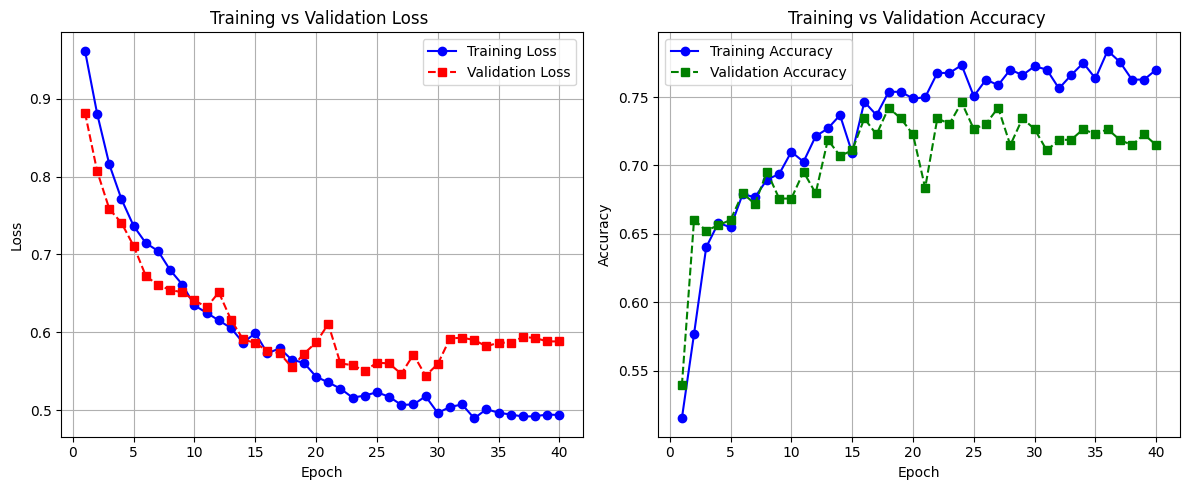

In [42]:
import matplotlib.pyplot as plt

def plot_train_val_curves(history, title_suffix=''):
    train_losses = history.history['loss'] + fine_history.history['loss']
    val_losses   = history.history['val_loss'] + fine_history.history['val_loss']
    train_acc    = history.history['accuracy'] + fine_history.history['accuracy']
    val_acc      = history.history['val_accuracy'] + fine_history.history['val_accuracy']
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r--s', label='Validation Loss')
    plt.title(f'Training vs Validation Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--s', label='Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_train_val_curves(history)

In [43]:
from sklearn.metrics import classification_report
import numpy as np

def tta_predict(model, img):
    aug_imgs = [
        img,
        tf.image.flip_left_right(img),
        tf.image.flip_up_down(img),
        tf.image.rot90(img)
    ]
    preds = [model.predict(tf.expand_dims(a, 0)) for a in aug_imgs]
    return np.mean(preds, axis=0)

y_true, y_pred = [], []
for images, labels in test_ds:
    for i in range(images.shape[0]):
        pred = tta_predict(model, images[i])
        y_pred.append(np.argmax(pred))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

<Figure size 700x600 with 0 Axes>

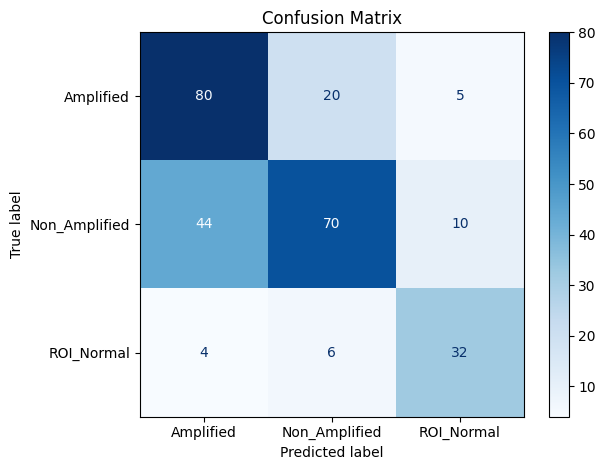

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [46]:
import shutil

shutil.make_archive(
    base_name="/kaggle/working/patches",
    format="zip",
    root_dir="/kaggle/working",
    base_dir="patches"
)


'/kaggle/working/patches.zip'